# AI-Dermotologist

This is a mini project that aims to build a AI classifier for deadly **skin cancer diagnose**. <br>
The ultimate goal is distinguish **maglignant [Melanoma]**(https://www.skincancer.org/skin-cancer-information/melanoma) (a.k.a black cancer, which is one of the most deadly cancer with only 15%-20% of survival rate) from **benign lesions** such as [nevus](http://missinglink.ucsf.edu/lm/dermatologyglossary/nevus.html) and [seborrheic keratoses](https://www.aad.org/public/diseases/bumps-and-growths/seborrheic-keratoses). <br>
The big motivation behind this project is that if Melanoma could be detected in its *early stage*, chances of cure will be much more optimistic. However, human dermotologists are not super accurate with this diagnose and there is a shortage per capita of them. <br>
The training, validation and test data of this project are pulled from the [ICIC 2017: Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a) challenge. In addition, this [paper](https://arxiv.org/pdf/1710.05006.pdf) provides a very comprehensive review of the state of the art approaches. <br>
Many of the techniques implemented in this notebook are inspired by the **[RECOD Titans at ISIC Chanlenge paper](https://arxiv.org/pdf/1710.05006.pdf)**(by Menegola A, Tavares J, Fornaciali M, Li LT, Avila S, Valle E. ) including *model selections, data augmentations, evaluation and SVM meta-learner.*

## Fastai
We are going to use **Fastai** libary in this notebook for prototyping. <br>
**Fastai** also provide excellent tools for hyper-parameter tuning, data cleaning, and other useful functions to make our iterative modelling provess easier

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import EarlyStoppingCallback

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
# import cv2
import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data
from torch import optim

from torchvision import datasets, transforms, models
from collections import OrderedDict


## Here we create our dataset from downloaded images in the 'data' folder

In [3]:
# We set max_warp to 0.0 since we don't have warping in this case

tfms = get_transforms(flip_vert=True, max_rotate=180.0,max_lighting=0.2, max_zoom=1.2, max_warp=0.0)

In [4]:
path = 'data'
bs = 64
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=114, bs=bs
                            ).normalize(imagenet_stats)

#### DataBunch is a fastai object that come with very handy properties that we can make use of
It's a good idea to run a sanity check on created dataset before going to actual prototyping

In [5]:
data.classes

['melanoma', 'nevus', 'seborrheic_keratosis']

In [6]:
data.c

3

In [7]:
data.train_ds

LabelList (2000 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data

In [8]:
data.valid_ds

LabelList (150 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data

In [9]:
data.device

device(type='cuda')

In [10]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Test: None>

### Let's do a visualization of our create dataset together with their labels

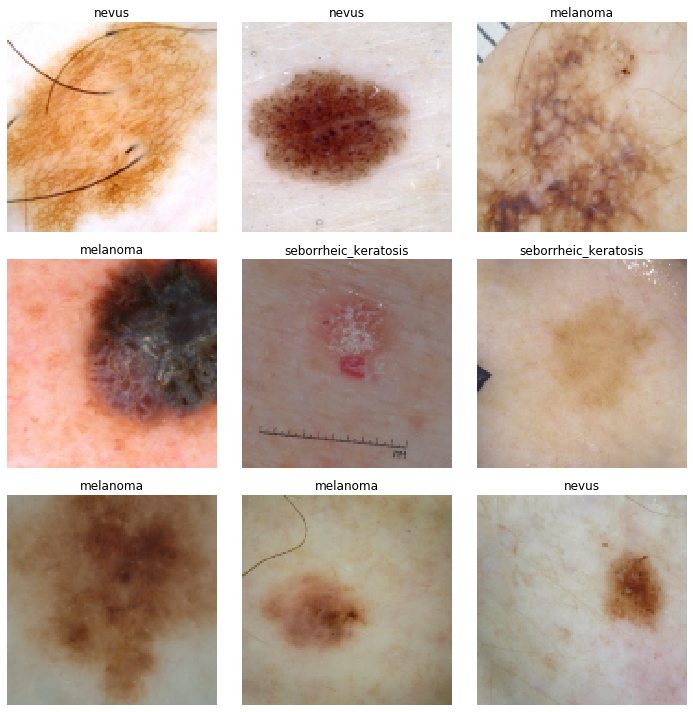

In [11]:
# we should see that the magnignant skin cancers are 
# actually pretty hard to distinguish
data.show_batch(rows=3, figsize = (10,10))

## Check the status of our GPU

In [11]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Total memory: 11719409664
Free memory: 11099242496
Used memory: 620167168
Device 0 : b'GeForce GTX 1080 Ti'


# Transfer learning
We create our model by downloading a pretrained ImageNet and modify its top layer according to the configuration of our dataset

## Model choice
There are going to be multiple models create in this notebook for ensemble learning.
We are going to start with a `ResNet34` and move to stronger learners.

## Metrics choice
We have chose accuracy and auc_roc_score to monitor how is our model doing during the training.
Note that: this is different from Scikit-learn in that the metrics we specified here has **no** impact on the training process. <br>
However, it's important to monitor the *metrics* that we are interested in in order to decide how will we further train our model.

In [16]:
top_3_accuracy = partial(top_k_accuracy, k=3)
learn = cnn_learner(data, models.resnet34, metrics = [accuracy, top_3_accuracy])
learn

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114),Image (3, 114, 114)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

We can see that FastAI has already modified the last few layers for us, so that it has a multiclass classification setup for 3 outputs. <br>
Very efficient prototyping.

#### Use LR Finder to pick a good learning rate

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


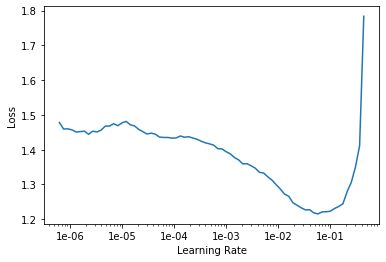

In [15]:
learn.recorder.plot()

#### Start training
The `fit_one_cycle()` methed are prooved to produce more consistent result
As for the `learning rate`, we pick the steepest slope. Make sure it's not too small here in the first training.

In [24]:
lr = 1e-3

In [31]:
learn.fit_one_cycle(5, slice(lr))

In [32]:
learn.save('stage-1')

## Stage-2
Unfreeze the whole network and get ready to train all of it

In [33]:
learn.unfreeze()

### Finding the good learning rate for different layers

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


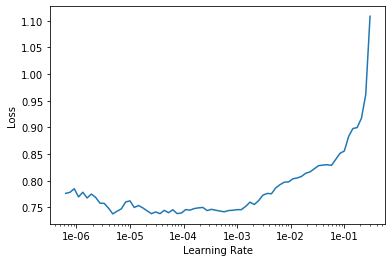

In [35]:
learn.recorder.plot()

#### Use `Slice()` to specify the lr_top and lr_bottom and everything in between

In [36]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,lr/5))

In [37]:
learn.save('stage-2')

In [17]:
bs = 32
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=bs
                            ).normalize(imagenet_stats)
learn.data = data

In [18]:
data.train_ds[0][0].shape

torch.Size([3, 224, 224])

In [40]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


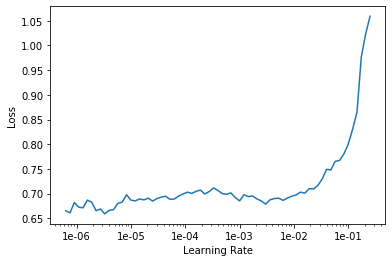

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
lr = 1e-3

In [43]:
learn.fit_one_cycle(5,slice(lr))

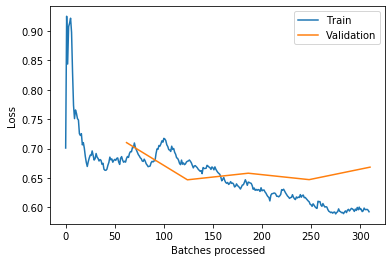

In [44]:
# comment: This is a good-looking loss-plotting
learn.recorder.plot_losses()

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


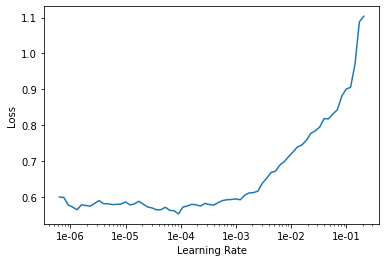

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(1e-5/2, lr/10))

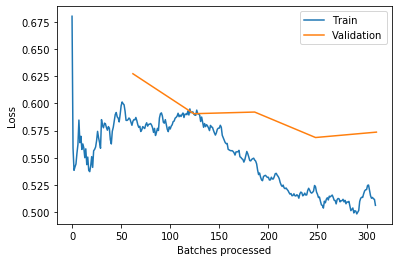

In [48]:
learn.recorder.plot_losses()

In [53]:
learn.save('resnet34-stage-4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


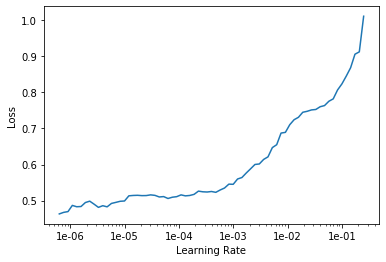

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
lr

0.001

In [56]:
learn.fit_one_cycle(5, slice(1e-6, lr/100))

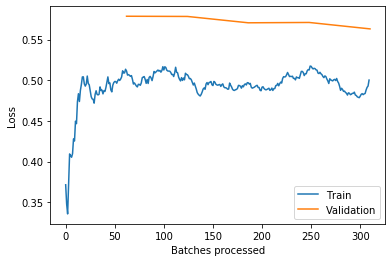

In [57]:
learn.recorder.plot_losses()

## Comment: This is a bad training. I'm going to discard this and live with "Res34-stage-4"

In [20]:
learn.load('resnet34-stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (2000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Valid: LabelList (150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nevus,nevus,nevus,nevus,nevus
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

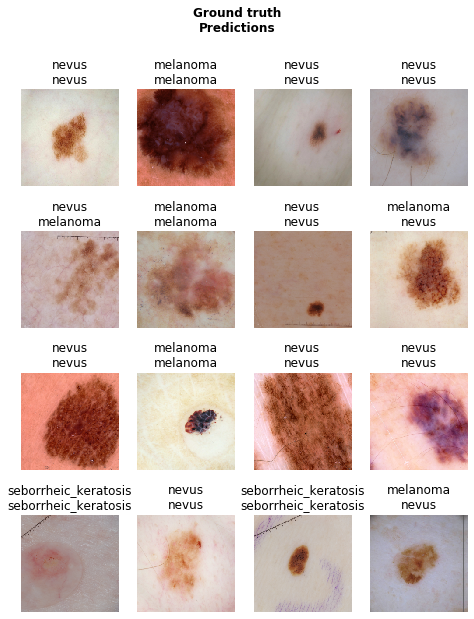

In [27]:
# This is how the learning performs with training data
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

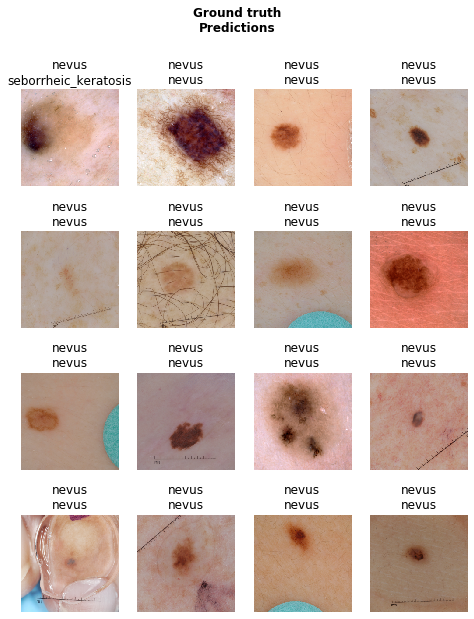

In [29]:
# This is how the learning performs with validation data (unseen data)
learn.show_results(ds_type=DatasetType.Valid, rows=4, figsize=(8,10))

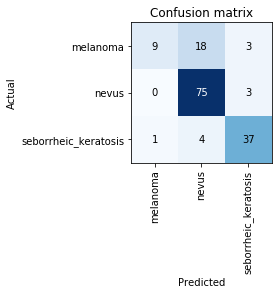

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Comment:<br>
This tells us that the Res34-classifier predicts the mojority of cancer to be *nevus* and we actually got a lot of the *melanoma* prediction wrong.

In [12]:
bs = 64
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=114, bs=bs
                            ).normalize(imagenet_stats)
bs = 32
data2 = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, bs=bs
                            ).normalize(imagenet_stats)

In [34]:
learn = cnn_learner(data, models.resnet101, metrics = accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


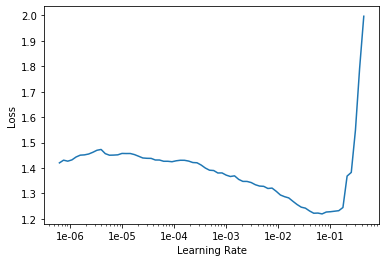

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-03
learn.fit_one_cycle(5, slice(lr))

In [23]:
learn.save("ResNet101-stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


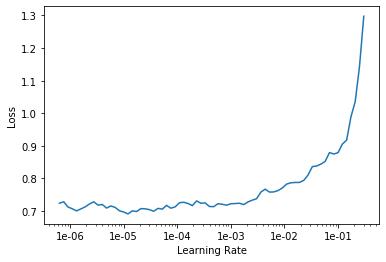

In [49]:
learn.load("ResNet101-stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(8, max_lr=slice(1e-5,lr/5))

In [51]:
learn.save("ResNet101-stage-2")

Remarks: not a good training. Discard this model

In [35]:
learn.load("ResNet101-stage-2")
# Change training dataset to higher resolution
learn.data = data2
data2.train_ds[0][0].shape

torch.Size([3, 224, 224])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


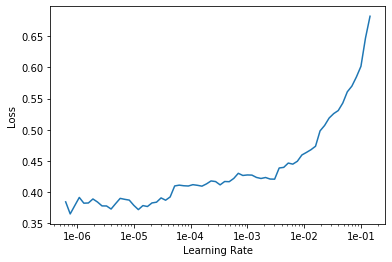

In [53]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [54]:
lr = 1e-4
learn.fit_one_cycle(5,slice(lr))

In [55]:
learn.save("ResNet101-stage-3")

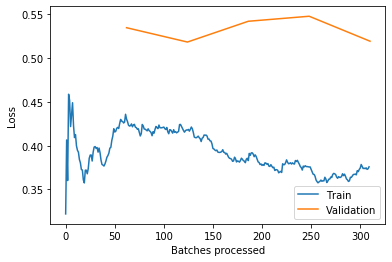

In [56]:
learn.recorder.plot_losses()

### Now the loss descent looks perfect

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


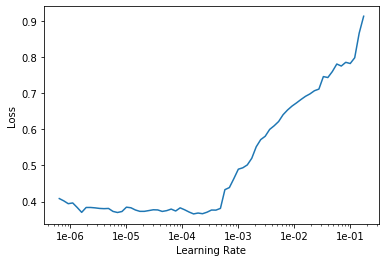

In [57]:
learn.load("ResNet101-stage-3")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

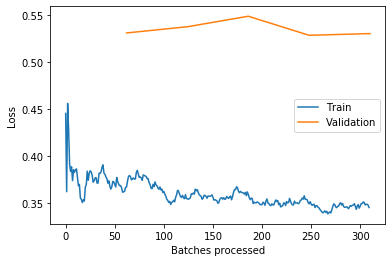

In [60]:
learn.recorder.plot_losses()

In [61]:
learn.save("ResNet101-stage-4")

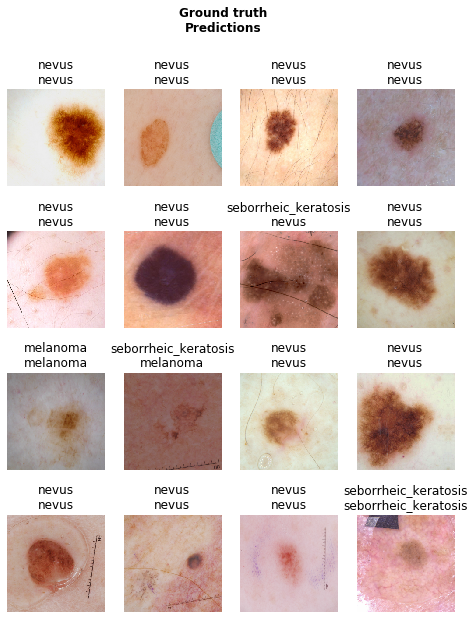

In [36]:
learn.load("ResNet101-stage-4")

#show how the model is doing with our training dataset
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

# Third base model to train: Resnet50

In [69]:
models.vgg??

In [50]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


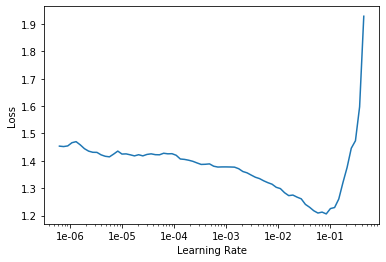

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
lr = 1e-02/2
learn.fit_one_cycle(5,slice(lr))

In [45]:
learn.fit_one_cycle(3,slice(lr))

In [46]:
learn.save("ResNet50-stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


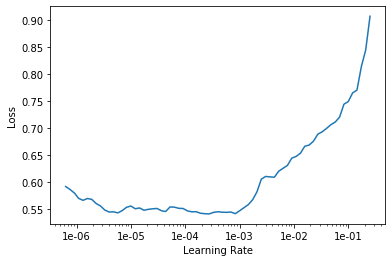

In [51]:
learn.load("ResNet50-stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [52]:
lr

0.005

In [53]:
learn.fit_one_cycle(5, slice(1e-04, lr/10))

In [54]:
learn.save("ResNet50-stage-2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


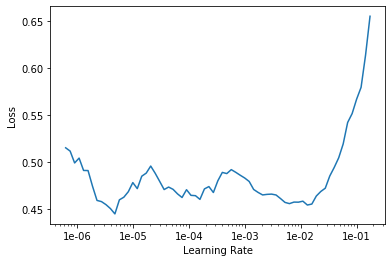

In [59]:
learn.load("ResNet50-stage-2")
learn.data = data2
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [60]:
lr = 1e-3
learn.fit_one_cycle(4, slice(lr))

In [61]:
learn.save("ResNet50-stage-3")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


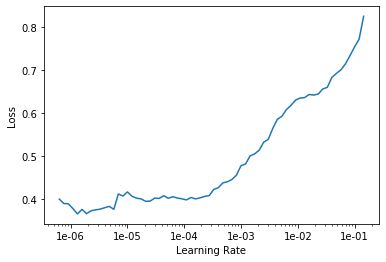

In [66]:
learn.load("ResNet50-stage-3")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(4, slice(1e-05,lr/10))

In [69]:
learn.save("ResNet50-stage-4")

##  DenseNet169
### lastly we will prepare our fourth model using Densenet169 which is the largest model involved in this project

In [13]:
learn = cnn_learner(data, models.densenet169, metrics = accuracy, callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=3)])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


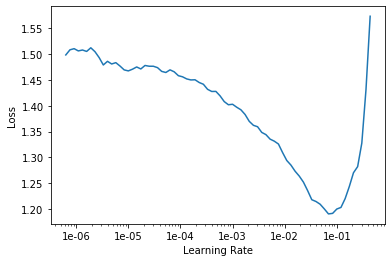

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr = 1e-02/2
learn.fit_one_cycle(6, lr)

In [16]:
learn.save("Densenet169-stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


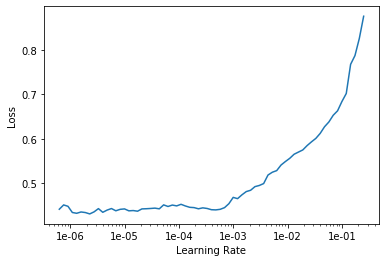

In [18]:
learn.load("Densenet169-stage-1")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,lr/5))

Epoch 4: early stopping


#### Note: this Densenet seems to ourperform ResNets. 
at least up untill this stage

In [20]:
learn.save("Densenet169-stage-2")

In [21]:
learn.data = data2
data2.train_ds[0][0].shape

torch.Size([3, 224, 224])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


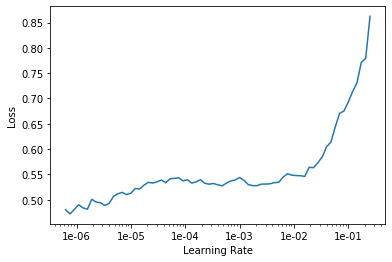

In [22]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-4
learn.fit_one_cycle(5, lr)

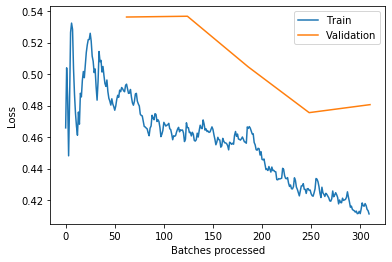

In [23]:
learn.save("Densenet169-stage-3")
learn.recorder.plot_losses()

In [19]:
learn.load("Densenet169-stage-3")
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [18]:
lr = 1e-3
learn.fit_one_cycle(8, slice(1e-5, lr/5))

Epoch 5: early stopping


In [29]:
learn.fit_one_cycle(8, slice(1e-5, lr/10))

In [43]:
learn.save("Densenet169-stage-4")

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

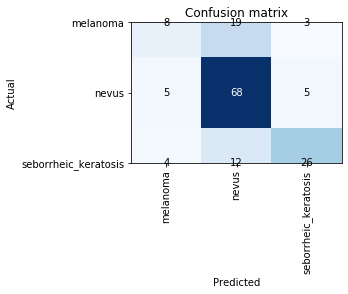

In [29]:
interp.plot_confusion_matrix()

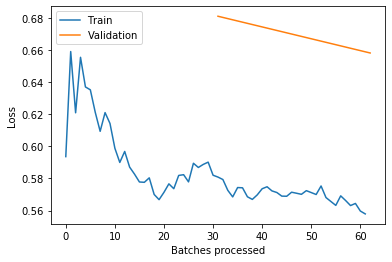

In [30]:
learn.recorder.plot_losses()

In [68]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

ModuleNotFoundError: No module named 'GPUtil'

In [ ]:
torch.cuda.is_available()

In [ ]:
import fastai.utils

In [ ]:
fastai.utils.show_install(1)

In [2]:
train_dir = ["data/train/melanoma",
             "data/train/nevus",
             "data/train/seborrheic_keratosis"
            ]

validation_dir = ["data/valid/melanoma",
                  "data/valid/nevus",
                  "data/valid/seborrheic_keratosis"
                 ]

test_dir = ["data/test/melanoma",
            "data/test/nevus",
            "data/test/seborrheic_keratosis"
           ]

#### Create a function to get image paths given their directory and volumn(per class)

In [3]:
def get_images_paths(directory, n_per_class):
    img_paths = []
    for i in range(3):
        cont = 1
        for file in glob.glob(directory[i]+"/*.jpg"):
            img_paths.append(file)
            if cont == n_per_class:
                break
            cont += 1
    return img_paths

In [4]:
# Test getting 15 training images (5 per class)
img_paths = get_images_paths(train_dir, 5)
print(f"The total number of image paths: {len(img_paths)}")
print(f"The actual content: \n {img_paths}")

The total number of image paths: 15
The actual content: 
 ['data/train/melanoma\\ISIC_0000002.jpg', 'data/train/melanoma\\ISIC_0000004.jpg', 'data/train/melanoma\\ISIC_0000013.jpg', 'data/train/melanoma\\ISIC_0000022.jpg', 'data/train/melanoma\\ISIC_0000026.jpg', 'data/train/nevus\\ISIC_0000000.jpg', 'data/train/nevus\\ISIC_0000001.jpg', 'data/train/nevus\\ISIC_0000003.jpg', 'data/train/nevus\\ISIC_0000006.jpg', 'data/train/nevus\\ISIC_0000007.jpg', 'data/train/seborrheic_keratosis\\ISIC_0012090.jpg', 'data/train/seborrheic_keratosis\\ISIC_0012103.jpg', 'data/train/seborrheic_keratosis\\ISIC_0012117.jpg', 'data/train/seborrheic_keratosis\\ISIC_0012155.jpg', 'data/train/seborrheic_keratosis\\ISIC_0012170.jpg']


In [5]:
# data inspection
images = []
for i ,path in enumerate(img_paths):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    print(f"Image {i+1} has the shape of: {image.shape}")

Image 1 has the shape of: (767, 1022, 3)
Image 2 has the shape of: (767, 1022, 3)
Image 3 has the shape of: (767, 1022, 3)
Image 4 has the shape of: (1129, 1504, 3)
Image 5 has the shape of: (1129, 1504, 3)
Image 6 has the shape of: (767, 1022, 3)
Image 7 has the shape of: (767, 1022, 3)
Image 8 has the shape of: (767, 1022, 3)
Image 9 has the shape of: (767, 1022, 3)
Image 10 has the shape of: (767, 1022, 3)
Image 11 has the shape of: (2848, 4288, 3)
Image 12 has the shape of: (2000, 3008, 3)
Image 13 has the shape of: (2000, 3008, 3)
Image 14 has the shape of: (2000, 3008, 3)
Image 15 has the shape of: (2000, 3008, 3)


## Visualization

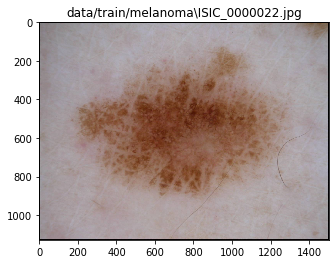

In [6]:
# This is a maglignant skin cancer
index = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(img_paths[index])
ax.imshow(images[index])

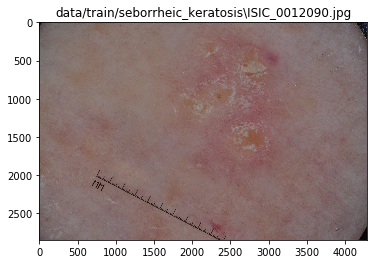

In [7]:
# This is a benign lesion
index = 10

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(img_paths[index])
ax.imshow(images[index])

## I think we can agree to some extent here that it's not an easy task to distinguish the maglignant kind from the benign kind

## This is when our deep learning models come in
### We are first going to try out stand alone image models that performed well with ImageNet challenges, and of course, transfer learning is applied here

The two models recommended in the paper [RECOD Titans at ISIC Challenge 2017](https://arxiv.org/pdf/1703.04819.pdf) are `ResNet-101` and `Inception-v4` (Inception_v3 is available in PyTorch so that's applied). <br>
Hence, they are used as our primary candidates. We skip the part where we apply VGG net as the baseline model.

In [8]:
# This is a very efficient model
model_Res101 = models.resnet101(pretrained=True)

model_Res101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
# We freeze the training in the bottom layers
for parameters in model_Res101.parameters():
    parameters.requires_grad = False

# Then, we replace the 1000 class ImageNet challenge output layer to a 3 class softmax linear layer
clasifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                       ('relu', nn.ReLU()),
                                       ('dropout', nn.Dropout(0.5)),
                                       ('output', nn.Linear(512, 3)),
                                       ('softmax', nn.Softmax(dim=1))]))
model_Res101.fc = clasifier

In [10]:
# A potentially stronger model (also, more complex)
model_Inception = models.inception_v3(pretrained=True)
model_Inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [11]:
# We freeze the training in the bottom layers
for parameters in model_Inception.parameters():
    parameters.requires_grad = False

# Then, we replace the 1000 class ImageNet challenge output layer to a 3 class softmax linear layer
clasifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                       ('relu', nn.ReLU()),
                                       ('dropout', nn.Dropout(0.5)),
                                       ('output', nn.Linear(512, 3)),
                                       ('softmax', nn.Softmax(dim=1))]))
model_Inception.fc = clasifier

## Create dataloaders

In [13]:
# construct data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    # This is recommended by the paper, in that, 128 by 128 produce similar results as compared to
    # high resolution: 256 by 256
    transforms.RandomCrop((224,224)),
    # Random rotation up to 270 degrees as recommended by the author
    transforms.RandomRotation(270),
    # 50% chance of flipping
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((256,256)),
    # note here we either perform do a  CenterCrop or do random crops and take an average
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

test_transform = valid_transform

In [14]:
root_path = "data/"

train_data = datasets.ImageFolder(root_path+'train', transform=train_transforms)
valid_data = datasets.ImageFolder(root_path+'valid', transform=valid_transform)
test_data = datasets.ImageFolder(root_path+'test', transform=test_transform)

# This Dataloader combine a dataset and a sampler.
trainloader = data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
validloader = data.DataLoader(dataset=valid_data, batch_size=32, shuffle=False)
testloader = data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [15]:
plt.rcParams["figure.figsize"] = [20,20]
Index_to_Cancer = {0:'Melanoma',1:'Nevus', 2:'Seborrheic_Keratosis'}
def show_image(images, labels, normalize=True):
    for t in range(images.shape[0]):
        plt.subplot(np.ceil(images.shape[0]/3),3,t+1)
        plt.text(0,1,f"Cancer type: {Index_to_Cancer[int(labels[t])]}", color='black', backgroundcolor='white', fontsize=20)
        image = images[t].numpy().transpose((1,2,0))
        if normalize:
            mean = np.array([0.485,0.456,0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std*image + mean
            image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

# Visualize data from our dataloader with their corresponding labels

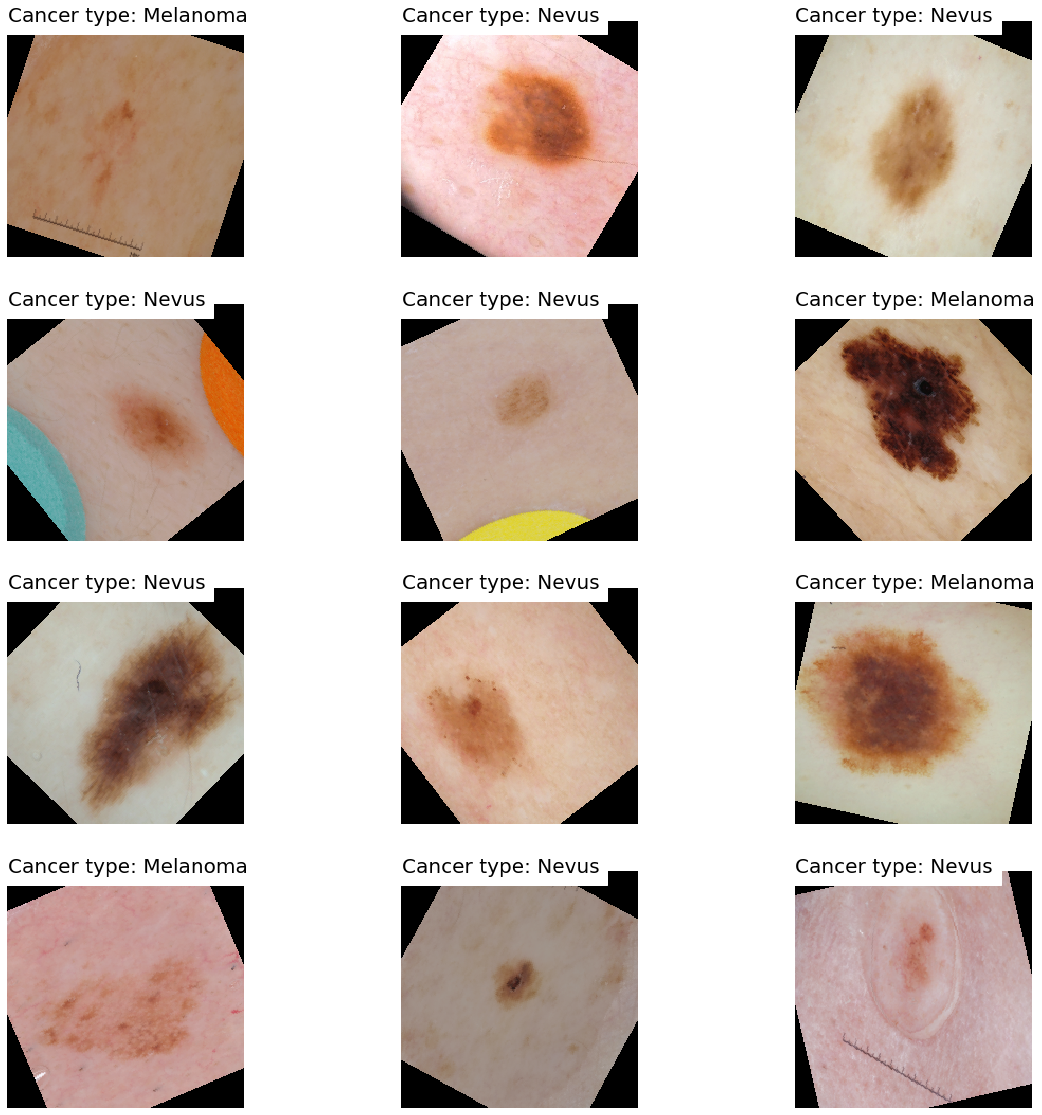

In [16]:
# Training data
images, labels = next(iter(trainloader))
num_to_show = 12
show_image(images[:num_to_show],labels[:num_to_show])

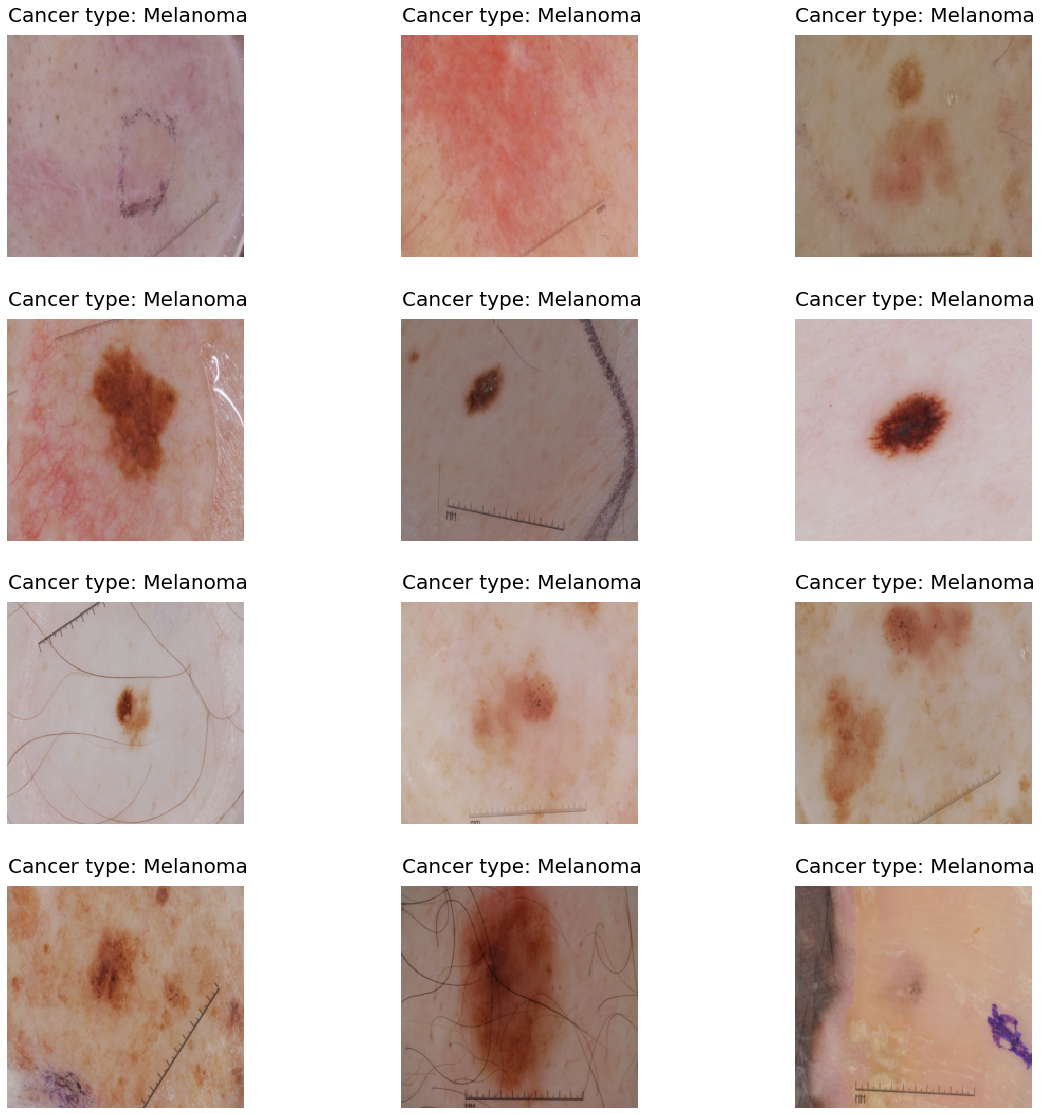

In [17]:
# Test data; we make sure the data without augmaentation is acceptable for the learner later
images, labels = next(iter(testloader))
num_to_show = 12
show_image(images[:num_to_show],labels[:num_to_show])

## Now. Time to Learn!

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
# Identify our GPU device
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

### Before training, we try to test what's the performance of classifier

In [20]:
def accuracy(validloader):
    correct_res101 = 0
    correct_incept = 0
    total = 0
    model_Res101.to(device)
    model_Inception.to(device)
    model_Res101.eval()
    model_Inception.eval()
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            outputs_res101 = model_Res101(images)
            outputs_incept = model_Inception(images)
            _, predict_res101 = torch.max(outputs_res101, 1)
            _, predict_incept = torch.max(outputs_incept, 1)
            total += labels.size(0)
            correct_res101 += (predict_res101 == labels).sum().item()
            correct_incept += (predict_incept == labels).sum().item()
        
    print(f"Accuracy of the Res101 is {100*correct_res101/total:.2f}%")
    print(f"Accuracy of the Inception is {100*correct_incept/total:.2f}%")          

In [21]:
# This is the performance of pre-trained models before our fine-tuning
accuracy(validloader)

Accuracy of the Res101 is 48.67%
Accuracy of the Inception is 28.00%


## Do an estimation of training time on each batch
This will help us finding out the how do we distribute our GPU resources

In [22]:
import time
# Estimation on ResNet101

criterion = nn.CrossEntropyLoss() # Because of softmax output
optimizer = optim.Adam(model_Res101.fc.parameters(), lr=0.001)

model_Res101.to(device)
model_Res101.train()

start = time.time()

images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)

outputs = model_Res101(images)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()
batch_time = time.time()-start
print(f"Device = {torch.cuda.get_device_name(0)}\nResNet101 time per batch: {batch_time:.2f} seconds")
print(f"Total time for one Epoch will be {batch_time*2000/64/60:.2f} mins")

Device = GeForce GTX 1080 Ti
ResNet101 time per batch: 10.38 seconds
Total time for one Epoce will be 5.41 mins


In [29]:
# Estimation on Inception

criterion = nn.CrossEntropyLoss() # Because of softmax output
optimizer = optim.Adam(model_Inception.fc.parameters(), lr=0.001)

model_Inception.to(device)
model_Inception.train()

start = time.time()

images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)

outputs = model_Inception(images)
loss = criterion(outputs.logits, labels)
loss.backward()
optimizer.step()
batch_time = time.time()-start
print(f"Device = {torch.cuda.get_device_name(0)}\nInception time per batch: {batch_time:.2f} seconds")
print(f"Total time for one Epoch will be {batch_time*2000/64/60:.2f} mins")

Device = GeForce GTX 1080 Ti
Inception time per batch: 9.73 seconds
Total time for one Epoce will be 5.07 mins


# Training Time

## ResNet101
### Define a function to monitor how we are doing on the validation set


In [51]:
()
learn.lr_find()
learn.recorder.plot()def validation_res(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs,labels).item()
        ps = torch.exp(outputs)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Res101.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

model_Res101.to(device)
running_loss = 0
step = 0
print_every = 10
epochs = 3

model_Res101.train()
for epoch in range(epochs):
    scheduler.step()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        step += 1
        optimizer.zero_grad()
        outputs = model_Res101(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % print_every == 0:
            model_Res101.eval()
            with torch.no_grad():
                test_loss, accuracy = validation_res(model_Res101, validloader, criterion)
                print(f"Epoch: {epoch+1}/{epochs}",
                      f"Training Loss: {running_loss/print_every:.3f}..",
                      f"Validation Loss: {test_loss/len(validloader)}..")
            running_loss = 0
            model_Res101.train()    

Epoch: 1/3 Training Loss: 0.851.. Validation Loss: 1.0639002203941346..
Epoch: 1/3 Training Loss: 0.873.. Validation Loss: 1.0638888955116272..
Epoch: 1/3 Training Loss: 0.862.. Validation Loss: 1.0638888955116272..
Epoch: 2/3 Training Loss: 0.887.. Validation Loss: 1.0638410329818726..
Epoch: 2/3 Training Loss: 0.870.. Validation Loss: 1.0638355255126952..
Epoch: 2/3 Training Loss: 0.876.. Validation Loss: 1.0637260556221009..
Epoch: 3/3 Training Loss: 0.859.. Validation Loss: 1.063908088207245..
Epoch: 3/3 Training Loss: 0.839.. Validation Loss: 1.0639222860336304..
Epoch: 3/3 Training Loss: 0.872.. Validation Loss: 1.063922142982483..


In [55]:
torch.save(model_Res101.state_dict(), "./model_Res101.pth")

In [56]:
def check_accuracy_on_test(testloader,model):    
    correct = 0
    total = 0
    with torch.no_grad():
        cont = 1
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            cont += 1
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100*correct/total)

In [59]:
model_Res101.to(device)
model_Res101.eval()
accuracy = check_accuracy_on_test(testloader,model_Res101)
print('Accuracy of the network on the 600 test images: %d %%' % accuracy)


Accuracy of the network on the 600 test images: 65 %


In [60]:
from PIL import Image

def load_image(path):
    image = Image.open(path)
    image = test_transforms(image)
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

def get_predictions(img_path):
    pred_rank1 = []
    pred_rank2 = []
    for img_path in img_path:
        img = load_image(img_path)
        prediction = model_Res101(img)
        pred_rank1.append(float(prediction.data[0][0]))
        pred_rank2.append(float(prediction.data[0][2]))
    return pred_rank1, pred_rank2